# CartPole: Balancing a Pole on a Moving Cart

<div align="center">
    <img src="./images/cart_pole.gif" width="300" alt="CartPole Environment">
</div>

The CartPole problem is a classic control problem where the task is to balance a pole attached by an un-actuated joint to a cart which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

An agent gets trained and interacts with the CartPole environment provided by Farama Gymnasium and tries to balance the pole on a moving cart.

## The Environment

The environment design for CartPole v1 in Gymnasium environment is as follows.

In [1]:
# Imports the necessary libraries

import gymnasium as gym                         # The CartPole environment
import matplotlib, matplotlib.pyplot as plt     # Plotting a frame of an episode
import time                                     # Adding pause between two successive steps in an episode to visualize it better
import numpy as np                              # Standard numeric functionalities and computations
from collections import defaultdict             # Simplifies creating a dictionary with default values for non-existing keys
from collections import deque                   # Queue with appending and popping from both ends
import random                                   # Random number generation
from itertools import count

import tensorflow as tf                         # Building and training neural networks
from tensorflow import keras

2025-09-25 12:06:02.683165: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-25 12:06:02.752438: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Creates the CartPole environment along with visual rendering of during the episode
env = gym.make('CartPole-v1', render_mode='rgb_array')  # Value 'rgb_array' is needed for visual step recording

**Observation & Action Space:**

In [3]:
# The observation space consists of 4 continuous values the ranges of which are mentoined below:

# [-4.8, 4.8]       (Cart position of cart on track. The episode terminates if the cart leaves the (-2.4, 2.4) range.
# [-Inf, Inf]       (Cart velocity)
# [-0.418, 0.418]   (Pole angle. Units are in radians. ±0.418 rad is equal to ±24°. The episode terminates if the pole angle is more than ±12° (±0.209 rad).)
# [-Inf, Inf]       (Pole angular velocity)

print("Observation space: ", env.observation_space)

# Shows action space of the environment. Two discrete actions are 0 (Move cart to left) and 1 (Move cart to right)
print("Action space: ", env.action_space)

Observation space:  Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space:  Discrete(2)


**Rewards:**
By default, a reward of **+1** is given for every step taken, including the termination step. The default reward threshold is **500** due to the time limit on the environment.

**Episode Termination:** The episode ends if the pole angle is greater than **±12°** or cart position is greater than **±2.4** (center of the cart reaches the edge of the display) or episode length is greater than **500**.

In [4]:
observation, info = env.reset()    # Resets the environment to start a new episode

print("Initial observation: ", observation)
print(f"Cart position: {observation[0]:.3f}, Cart velocity: {observation[1]:.3f}, \
      Pole angle: {observation[2]:.3f}, Pole angular velocity: {observation[3]:.3f}")

Initial observation:  [-0.03260717  0.03884414  0.03323567  0.03092082]
Cart position: -0.033, Cart velocity: 0.039,       Pole angle: 0.033, Pole angular velocity: 0.031


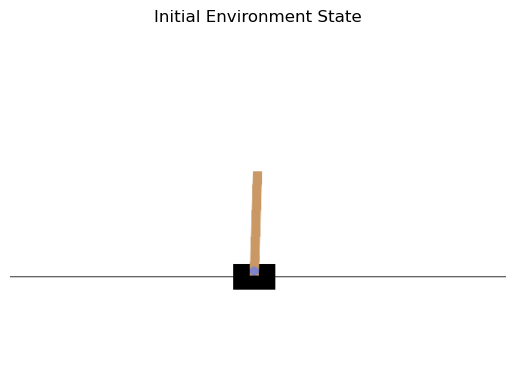

In [5]:
# Let's now visualize the initial state of the environment to correspond to the initial observation value received above

plt.imshow(env.render())
plt.axis('off')
plt.title('Initial Environment State')
plt.show()

## Balancing the Pole with Random Actions

Balancing the pole with random actions (0 to move left and 1 to move right) over an episode.

In [6]:
env.reset()

# Wraps the environment to record statistics e.g. total reward, step count for one episode
# To calculate manually, uncomment the relevant lines below
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=1)

terminated = False          # Tracks if the episode is over to stop the loop
# total_reward = 0          # Uncomment to accumulate rewards for an episode manually
# step_count = 0            # Unceomment to count total steps taken in an episode manually

while not terminated:
    action = env.action_space.sample()      # Samples an  action randomly. Returns 0 (move left) or 1 (move right).
    
    # step_count += 1                       # Uncomment to increment step counter manually

    # Takes a step with the sampled action. It returns five values:
    # 1. observation: Array of 4 values [cart_position, cart_velocity, pole_angle, pole_angular_velocity]
    # 2. reward: +1 for every step taken, including the terminal state
    # 3. terminated: True if pole angle > ±12° or cart position > ±2.4 units
    # 4. truncated: True if episode length >= 500 timesteps (default in CartPole v1)
    # 5. info: Additional information (empty dictionary in CartPole v1)
    observation, reward, terminated, truncated, info = env.step(action)

    # total_reward += reward                # Uncomment to accumulate rewards manually.
    
    terminated = terminated or truncated    # Checks if the episode is over

print(f"Episode is completed. Total reward: {env.return_queue[0]}, Steps taken: {env.length_queue[0]}")

Episode is completed. Total reward: 46.0, Steps taken: 46


In [7]:
env.close() # Closes the environment to free up resources

Now, an intelligent agent will be build to keep the pole balanced for longer period of time resulting larger total rewards over each episode.

## The Q-Learning Agent

An agent gets trained using Q-learning to develop a policy that tells the agent which action to take in each situation to maximize long-term rewards. The key Q-learning components are:

1. **Q-Table**: Maps state-action pairs to expected rewards
2. **ε-greedy Policy**: Balance exploration and exploitation
3. **Learning Rate (α)**: Controls how much new information overrides old
4. **Discount Factor (γ)**: Balances immediate vs future rewards
5. **Exploration Decay**: Gradually reduce random actions

**State Space Discretization**
Since CartPole has continuous state space, so it must be discretized into bins as follows.
- Cart Position: [-4.8, 4.8] → 8 bins
- Cart Velocity: [-4, 4] → 8 bins
- Pole Angle: [-0.418, 0.418] → 8 bins
- Pole Angular Velocity: [-4, 4] → 8 bins

In [2]:
class QLearningAgent:
    """Q-learning agent for the CartPole v1 environment."""

    def __init__(self, env, learning_rate=0.1, discount_factor=0.95, 
                 initial_epsilon=1.0, epsilon_decay=0.995, final_epsilon=0.01):
        """
        Initialize the Q-learning agent for the CartPole v1 environment.
        
        Args:
            env: The CartPole v1 environment
            learning_rate: How quickly the agent learns from new experiences (α)
            discount_factor: How much future rewards are valued (γ)
            initial_epsilon: Starting exploration rate
            epsilon_decay: Rate at which exploration decreases
            final_epsilon: Minimum exploration rate
        """
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        # Defines the state space discretization
        self.n_bins = 8                     # Number of bins (same being used here for all state variables)
        self.state_bins = {
            'cart_position': np.linspace(-4.8, 4.8, self.n_bins),
            'cart_velocity': np.linspace(-4, 4, self.n_bins),
            'pole_angle': np.linspace(-0.418, 0.418, self.n_bins),
            'pole_angular_velocity': np.linspace(-4, 4, self.n_bins)
        }
        
        # Initialize Q-table with optimistic initial values (1.0) to encourage exploration
        self.q_table = defaultdict(lambda: np.ones(env.action_space.n))
        
        self.training_rewards = []          # Track learning progress over episodes
        
    def discretize_state(self, observation):
        """
        Convert continuous state values to discrete state values.
        
        Args:
            observation: [cart position, cart velocity, pole angle, pole angular velocity]
            
        Returns:
            tuple: Discretized state representation
        """

        discretized = []
        for i, (name, bins) in enumerate(self.state_bins.items()):
            discretized.append(np.digitize(observation[i], bins))
        
        return tuple(discretized)
    
    def get_action(self, state):
        """
        Choose action using ε-greedy policy.
        
        Args:
            state: Current state (discretized)
            
        Returns:
            int: Chosen action (0: left, 1: right)
        """
    
        if np.random.random() < self.epsilon:       # Explores by choosing random action
            return self.env.action_space.sample()
    
        return np.argmax(self.q_table[state])       # Exploits by choosing best action based on Q-values
    
    def update_q_value(self, state, action, reward, next_state, terminated):
        """
        Updates Q-value for state-action pair using the Bellman equation.
        
        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            terminated: Whether episode ended
        """

        # Gets best future value (0 if terminated)
        best_next_value = 0 if terminated else np.max(self.q_table[next_state])
        
        # Calculates target Q-value using Bellman equation
        target_q = reward + self.discount_factor * best_next_value
        
        # Gets the current q_value for the state-action pair, calculates the delta and then
        # apply learning rate to update Q_value for the state-action pair.
        current_q = self.q_table[state][action]
        self.q_table[state][action] = current_q + self.learning_rate * (target_q - current_q)
    
    def decay_epsilon(self):
        """Decays exploration rate by a multiplication factor"""
        self.epsilon = max(self.final_epsilon, 
                          self.epsilon * self.epsilon_decay)
    
    def train(self, n_episodes=1000):
        """
        Trains the agent for a specified number of episodes.
        
        Args:
            n_episodes: Number of training episodes

        Returns:
            list: Rewards obtained in each of the specified number of episodes
            list: Steps taken in each of the specified number of episodes
        """

        total_rewards = []                      # Store rewards for current episodes
        total_steps = []                              # Store steps for current episodes

        for episode in range(n_episodes):
            total_reward, steps = self.train_episode()
            total_rewards.append(total_reward)
            total_steps.append(steps)

        return total_rewards, total_steps
    
    def train_episode(self):
        """
        Trains the agent for one episode.
        
        Returns:
            float: Total reward for the episode
            int: Steps taken in the episode
        """
        
        state, _ = self.env.reset()                 # Resets environment and gets initial state
        state = self.discretize_state(state)        # Discretizes the initial state
        total_reward = 0                            # Tracks total reward for the episode
        steps = 0                                   # Tracks steps taken in the episode
        done = False                                # Tracks if the episode is over to stop the loop
        
        while not done:
            action = self.get_action(state)         # Chooses action using ε-greedy policy
            next_observation, reward, terminated, truncated, _ = self.env.step(action)  # Takes action and receives feedback
            
            next_state = self.discretize_state(next_observation)                # Discretizes the new state
            self.update_q_value(state, action, reward, next_state, terminated)  # Learns by updating Q-table
            
            state = next_state                      # Next state becomes current state
            total_reward += reward                  # Accumulates reward for the current episode
            steps += 1                              # Increments step count
            done = terminated or truncated          # Checks if the episode is over
        
        self.decay_epsilon()                        # Decays exploration rate after episode
        
        self.training_rewards.append(total_reward)  # Stores total reward for the episode for later reference
        
        return total_reward, steps                  # Returns total reward and steps for the current episode

### Training the Q-Learning Agent

Let's create an instance of our Q-learning agent and train it over multiple episodes.

In [3]:
# NOTE: Training the agent may take a few minutes to complete.

n_episodes = 10000                      # Number of episodes to train the agent

env = gym.make('CartPole-v1')           # Creates the CartPole environment

# Creates the agent
agent = QLearningAgent(env, 
             learning_rate=0.1,         # Learning rate
             discount_factor=0.95,      # Discount factor
             initial_epsilon=1.0,       # Initial exploration rate
             epsilon_decay=0.995,       # Exploration decay rate
             final_epsilon=0.01)        # Minimum exploration rate

# Trains the agent. It may take a few minutes to complete.
total_rewards, total_steps = agent.train(n_episodes)

env.close()                             # Closes the environment to free up resources

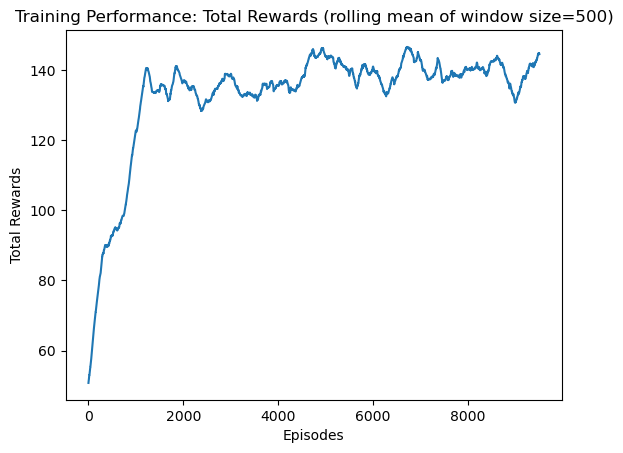

In [4]:
window_size = 500

# There could be high variance in rewards over episodes due to exploration-exploitation trade-off.
# To make sense of the rewards trend, the curve is plotted over a rolling mean with a window size of 500 episodes.
rolling_mean = np.convolve(total_rewards, np.ones(window_size)/window_size, mode='valid')   # 
plt.plot(rolling_mean)
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title(f'Training Performance: Total Rewards (rolling mean of window size={window_size})')
plt.show()

### Evaluating the Trained Q-Learning Agent
Generalizing trained agent's performance by running a few evaluation episodes with rendering enabled and no exploration (ε = 0).

In [ ]:
# Create environment for evaluation with rendering mode (dependency on `pygame` package) 
# to visualize the agent's peformance.
env = gym.make('CartPole-v1', render_mode='human')

n_eval_episodes = 5                         # Number of evaluation episodes
eval_total_rewards = []
eval_total_steps = []

for episode in range(n_eval_episodes):
    state, _ = env.reset()
    state = agent.discretize_state(state)
    episode_reward = 0
    episode_steps = 0
    terminated = False
    
    while not terminated:
        action = np.argmax(agent.q_table[state])    # Chooses best action based on learned Q-values (with no exploration)
        
        next_observation, reward, terminated, truncated, _ = env.step(action)   # Takes action and receives feedback
        next_state = agent.discretize_state(next_observation)                   # Discretizes the new state
        
        state = next_state                  # Next state becomes current state
        episode_reward += reward            # Accumulates reward for the current episode
        episode_steps += 1                  # Increments step count
        terminated = terminated or truncated      # Checks if the episode is over
        
        time.sleep(0.01)    # Adds a small delay to better visualize the agent's behavior
    
    eval_total_rewards.append(episode_reward)
    eval_total_steps.append(episode_steps)
    print(f"Evaluation Episode {episode + 1}: Reward = {episode_reward}, Steps = {episode_steps}")

print(f"\nAverage Evaluation Reward: {np.mean(eval_total_rewards):.2f}")

env.close()    # Closes the evaluation environment to free up resources

Evaluation Episode 1: Reward = 139.0, Steps = 139
Evaluation Episode 2: Reward = 150.0, Steps = 150
Evaluation Episode 3: Reward = 148.0, Steps = 148
Evaluation Episode 4: Reward = 142.0, Steps = 142
Evaluation Episode 5: Reward = 147.0, Steps = 147

Average Evaluation Reward: 145.20


It shows that averaged rewards received by the trained agent is much more than the average rewards received when just random actions were taken as experimented in the beginning of this notebook.

## The Q-Network Agent

In this notebook, a Q-Network agent is implemented using TensorFlow. Q-Network is better suited for environments with continuous state spaces like CartPole because it eliminates the need for state discretization by generalizing across similar states and capturing complex state-action relationships.

The implementation includes the following parts:

- **Neural Network:** The neural network consists of fully connected layers with inputs equal to the number of state observations and outputs equal to the number of actions from the actions space.

- **Experience Replay:** The agent observes state transition when it takes actions against a present state and stores these transitions as data to train neural network model.

- **Target Network with Soft Updates:** To stabilize training, two networks are maintained - a policy network and a target network. The target network is used to compute target Q-values and is updated slowly (τ = 0.005) to track the policy network, reducing oscillations in training.

- **Epsilon-greedy Exploration:** Balances between exploring new actions (random) and exploiting learned knowledge (using network predictions) with a decaying exploration rate.

In [2]:
# Shows model's training performance live during training

is_ipython = 'inline' in matplotlib.get_backend()   # Makes plot interactive to show learning progress in real-time
if is_ipython:
    from IPython import display
plt.ion()                                           # Switches 'on' interactive mode of plot

env = gym.make("CartPole-v1")                       # Creates the CartPole environment

### Experience Replay

In [3]:
class ReplayMemory:
    """Stores state transitions and samples them randomly."""

    def __init__(self, capacity):
        """
        Allocates memory to store state transitions up to the specified capacity.
        
        Args:
            capacity: Maximum number of transitions to store
        """
        self.memory = deque(maxlen=capacity)
    
    def push(self, state, action, next_state, reward, done):
        """
        Saves a state transition

        Args:
            state: Current state
            action: Action taken
            next_state: Next state transitioned to
            reward: Reward received
            done: Whether the episode ended
        """
        self.memory.append((state, action, next_state, reward, done))
    
    def sample(self, batch_size):
        """
        Sample a batch of transitions
        
        Args:
            batch_size: Number of transitions to sample out
        
        Returns:
            tuple: Batches of (states, actions, next_states, rewards, dones)
        """
        batch = random.sample(self.memory, batch_size)
        
        # Converts list of tuples to tuple of lists as part of preprocessing for training
        states, actions, next_states, rewards, dones = map(np.array, zip(*batch))
        
        return states, actions, next_states, rewards, dones
    
    def __len__(self):
        return len(self.memory)

### Q-Network Model

The network takes the state as input and outputs Q-values for each possible action.

In [4]:
class QNetwork(tf.keras.Model):
    """Fully connnected feed-forward neural network to approximate Q-values."""
    
    def __init__(self, n_observations, n_actions):
        """
        Initializes the dense layers.
        
        Args:
            n_observations: Number of state observations (input dimensions)
            n_actions: Number of possible actions (output dimensions)
        """
        super(QNetwork, self).__init__()
        self.layer1 = tf.keras.layers.Dense(128, activation='relu')
        self.layer2 = tf.keras.layers.Dense(128, activation='relu')
        self.layer3 = tf.keras.layers.Dense(n_actions)
        
    def call(self, x):
        """
        Passes forward through the network.

        Args:
            x: Input states

        Returns:
            Tensor: Q-values for each action
        """
        x = self.layer1(x)
        x = self.layer2(x)
        return self.layer3(x)

In [5]:
state, info = env.reset()                           # Resets the environment to start a new episode

n_actions = env.action_space.n                      # Gets the number of actions
n_observations = len(state)                         # Gets the number of observations

policy_net = QNetwork(n_observations, n_actions)    # Creates policy network
target_net = QNetwork(n_observations, n_actions)    # Create target network

target_net.set_weights(policy_net.get_weights())    # Copies weights from policy net to target net

### Training Parameters and Utilities

In [6]:
# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99                        # Discount factor
EPS_START = 0.9                     # Starting value of epsilon (for exploration)
EPS_END = 0.01                      # Final value of epsilon
EPS_DECAY = 2500                    # Decay rate for epsilon
TAU = 0.005                         # For soft update of target network parameters
LEARNING_RATE = 3e-4                # Learning rate

memory = ReplayMemory(10000)        # Initializes replay memory

optimizer = tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE)      # Initializes optimizer

# Tracking variables
steps_done = 0
total_reward = []

def select_action(state):
    """
    Selects action using epsilon-greedy action selection method.
    
    Args:
        state: Current state

    Returns:
        int: Chosen action (0: left, 1: right)
    """
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:                  # Exploits Q-values learened by policy network
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, 0)
        q_values = policy_net(state_tensor)
        return tf.argmax(q_values[0]).numpy()   # Returns the action with highest Q-value
    else:
        return env.action_space.sample()        # Returns random action as part of exploration

def plot_total_rewards(show_result=False):
    """
    Plots the total rewards received in each episode

    Args:
        show_result: If True, shows the final result plot (without clearing previous outputs)
    """
    plt.figure(1)
    plt.clf()
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Training Performance')
    plt.plot(total_reward)
    
    plt.pause(0.001)    # Pauses for plots to get updated
    
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

2025-09-25 12:06:38.384861: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Training Loop

In [ ]:
@tf.function
def train_step(states, actions, next_states, rewards, dones):
    """
    Single optimization step
    
    Args:
        states: Batch of current states
        actions: Batch of actions taken
        next_states: Batch of next states
        rewards: Batch of rewards received
        dones: Batch of episode completion flags

    Returns:
        Tensor: Computed loss for the batch
    """

    actions_one_hot = tf.one_hot(actions, n_actions)    # Convert actions to one-hot vectors for gathering
    
    with tf.GradientTape() as tape:
        # Computes current Q-values
        current_q_values = policy_net(states)
        current_q_values = tf.reduce_sum(current_q_values * actions_one_hot, axis=1)
        
        # Computes next Q-values using target network
        next_q_values = target_net(next_states)
        next_q_values = tf.reduce_max(next_q_values, axis=1)
        
        # Computes expected Q-values
        expected_q_values = rewards + GAMMA * next_q_values * (1 - tf.cast(dones, tf.float32))
        
        # Computes (Huber) loss as it acts like the mean squared error when the error is small, 
        # but like the mean absolute error when the error is large - this makes it more robust to
        # outliers when the estimates of Q-values are very noisy. 
        loss = tf.keras.losses.Huber()(expected_q_values, current_q_values)
    
    grads = tape.gradient(loss, policy_net.trainable_variables)             # Computes gradients
    grads = [tf.clip_by_value(grad, -100, 100) for grad in grads]           # Clips gradients
    optimizer.apply_gradients(zip(grads, policy_net.trainable_variables))   # Updates policy network weights
    
    return loss     # Returns the computed loss

def optimize_model():
    """Perform one step of optimization"""
    
    if len(memory) < BATCH_SIZE:
        return
    
    states, actions, next_states, rewards, dones = memory.sample(BATCH_SIZE)    # Samples from replay memory
    
    # Converts samples to tensors
    states = tf.convert_to_tensor(states, dtype=tf.float32)
    actions = tf.convert_to_tensor(actions, dtype=tf.int64)
    next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
    rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
    dones = tf.convert_to_tensor(dones, dtype=tf.bool)
    
    loss = train_step(states, actions, next_states, rewards, dones)    # Performs training step
    
    # Performs soft updates to target network
    
    target_weights = target_net.get_weights()
    policy_weights = policy_net.get_weights()
    
    # The target network is updated at every step with a soft update controlled
    # by the defined hyperparameter `TAU`.
    for i in range(len(target_weights)):
        target_weights[i] = TAU * policy_weights[i] + (1 - TAU) * target_weights[i]
    
    target_net.set_weights(target_weights)

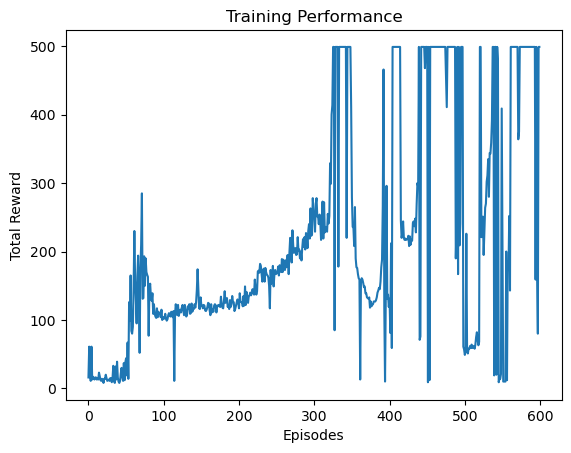

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Model training was completed.


In [8]:
# NOTE: Following steps to train the model may take a few tens of minutes to complete on CPUs.

n_episodes = 600    # Number of episodes

# Trains the models over the specified number of episodes
for episode in range(n_episodes):
    state, info = env.reset()
    episode_reward = 0
    done = False

    while not done:
        # Selects and performs action
        action = select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        memory.push(state, action, next_state, reward, done)   # Store the transition in memory
        
        state = next_state          # Next state becomes current state

        if not done:                # Rewards increments only if episode is not done
            episode_reward += reward
        
        optimize_model()            # Performs one step of optimization
        
        if done:                    # Total rewards get stored and plot gets updated once episode is done
            total_reward.append(episode_reward)
            plot_total_rewards()
            break
            
plot_total_rewards(show_result=True)
plt.ioff()                              # Switches 'off' interactive mode of plot
plt.show()

print('Model training was completed.')


In [9]:
env.close() # Closes the environment to free up resources

### Evaluating the Trained Q-Network Agent

In [ ]:
# Creates environment for evaluation with rendering
env = gym.make('CartPole-v1', render_mode='human')

# Runs evaluation episodes
n_eval_episodes = 5
eval_rewards = []

for episode in range(n_eval_episodes):
    state, _ = env.reset()

    episode_reward = 0      # Accumulates reward for the current episode
    done = False            # Checks if the episode is over
    
    while not done:
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, 0)
        q_values = target_net(state_tensor)                 # Uses target network for evaluation (without exploration)
        action = tf.argmax(q_values[0]).numpy()
            
        next_state, reward, terminated, truncated, _ = env.step(action)     # Takes the action
        
        state = next_state                                  # Next state becomes current state
        episode_reward += reward            
        done = terminated or truncated      
        
    eval_rewards.append(episode_reward)     # Stores total reward for the episode
    print(f"Evaluation Episode {episode + 1}: Reward = {episode_reward}")

print(f"\nAverage Evaluation Reward: {np.mean(eval_rewards):.2f}")

env.close()     # Closes the evaluation environment

Evaluation Episode 1: Reward = 500.0
Evaluation Episode 2: Reward = 500.0
Evaluation Episode 2: Reward = 500.0
Evaluation Episode 3: Reward = 500.0
Evaluation Episode 3: Reward = 500.0
Evaluation Episode 4: Reward = 500.0
Evaluation Episode 4: Reward = 500.0
Evaluation Episode 5: Reward = 500.0

Average Evaluation Reward: 500.00
Evaluation Episode 5: Reward = 500.0

Average Evaluation Reward: 500.00


The above performance shows that Q-Network agent outperformed non-neural network based Q-Learing agent by significant mergin.